In [1]:
from BinaryLayers import *

In [17]:
# For Binary Layers
H = 1
deterministic = True

# For Training
batch_size = 128
num_epochs = 200

# For batchnorm
epsilon = 1e-4
alpha = .15

# For the optimizer
learning_rate = .3
min_learning_rate = 3e-5
decay = (learning_rate - min_learning_rate) / num_epochs

# Set GPU
device = torch.device("cuda")

In [18]:
class BinaryConnect(Module):
    def __init__(self):
        super(BinaryConnect, self).__init__()
        self.net = torch.nn.Sequential(
            BinaryDense(28*28, 1024),
            torch.nn.BatchNorm1d(1024, eps=1e-4, momentum=0.15),
            torch.nn.ReLU(),
            
            BinaryDense(1024, 1024),
            torch.nn.BatchNorm1d(1024, eps=1e-4, momentum=0.15),
            torch.nn.ReLU(),
            
            BinaryDense(1024, 1024),
            torch.nn.BatchNorm1d(1024, eps=1e-4, momentum=0.15),
            torch.nn.ReLU(),
            
            BinaryDense(1024, 10),
            torch.nn.BatchNorm1d(10, eps=1e-4, momentum=0.15),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x):
        return self.net(x)

In [19]:
t = transforms.Compose(
    [
       transforms.ToTensor(),
       transforms.Normalize(mean=(0), std=(1))
    ]
)

dl_train = DataLoader(
    torchvision.datasets.MNIST(
        "/data/mnist",
        download=True,
        train=True,
        transform=t,
        target_transform=torchvision.transforms.Compose([
            lambda x:torch.LongTensor([x]), # or just torch.tensor
            lambda x:torch.nn.functional.one_hot(x, 10)
        ])
    ),
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)
dl_valid = DataLoader(
    torchvision.datasets.MNIST(
        "/data/mnist",
        download=True,
        train=False,
        transform=t,
        target_transform=torchvision.transforms.Compose([
            lambda x:torch.LongTensor([x]), # or just torch.tensor
            lambda x:torch.nn.functional.one_hot(x, 10)
        ])
    ),
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)
num_in = 28 * 28

# layers = []
# layers.append(torch.nn.Dropout(dropout_in))
# for i in range(n_hidden_layers):
#     layers.append(BinaryDense(num_in, num_units, H=H, deterministic=deterministic))
# #     layers.append(torch.nn.BatchNorm1d(num_units))
# #     layers.append(torch.nn.Linear(num_in, num_units))
#     layers.append(torch.nn.Sigmoid())
# #     layers.append(torch.nn.Dropout(dropout_hidden))
#     num_in = num_units
# # layers.append(torch.nn.Linear(num_in, 10))
# layers.append(BinaryDense(num_in, 10, H=H, deterministic=deterministic))
# # layers.append(torch.nn.BatchNorm1d(10, eps=epsilon, momentum=alpha))
# layers.append(torch.nn.Softmax(1))
# model = torch.nn.Sequential(*layers).to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=30)
# # optimizer = torch.optim.Adam(model.parameters(), lr=3)
# lossfunction = torch.nn.MSELoss()

In [20]:
def train(model, num_epochs, dl_train, dl_valid, device, lossfunction, optimizer):
    losses = [0] * num_epochs
    val_losses = [0] * num_epochs
    total_steps = len(dl_train) * num_epochs


    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        model.train()
        ect = 0
        ecv = 0
        ett = 0
        etv = 0
        for i, (input, target) in enumerate(dl_train):
            if i % 10 == 0:
                print(i, end=" ")
            optimizer.zero_grad()
            input = torch.reshape(input, (-1, 28 * 28)).to(device)
            target = torch.reshape(target, (-1, 10)).to(device)
            output = model(input)

            loss = lossfunction(output, target.float())
            losses[epoch] += loss.item()
            loss.backward()

            optimizer.step()

        model.eval()
        tot_acc = 0
        with torch.no_grad():
            for j, (input, target) in enumerate(dl_valid):
                input = torch.reshape(input, (-1, 28*28)).to(device)
                target = target.reshape((-1, 10)).to(device)
                output = model(input)
                loss = lossfunction(output, target.float())
                val_losses[epoch] += loss.item()
                tot_acc = (tot_acc * j + int(sum(torch.argmax(target, -1) == torch.argmax(output, -1))) / len(target)) / (j + 1)

        print("")
        print("Epoch training loss" , losses[epoch] / len(dl_train))
        print("Epoch valid loss" , val_losses[epoch] / len(dl_valid))
        print("Validation Accuracy:", tot_acc)
    return losses, val_losses

In [21]:
model = BinaryConnect().to(device)
lossfunction = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=decay)

In [22]:
losses, val_losses = train(model, num_epochs, dl_train,
                           dl_valid, device, lossfunction, optimizer)

Epoch 1
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 
Epoch training loss 5.880400660710457
Epoch valid loss 5.860613792370527
Validation Accuracy: 0.30448717948717946
Epoch 2
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 
Epoch training loss 5.859939105490334
Epoch valid loss 5.85904582341512
Validation Accuracy: 0.3697916666666667
Epoch 3
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 
Epoch training loss 5.858418328130347
Epoch valid loss 5.8574705857497
Validation Accuracy: 0.453125
Epoch 4
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 29

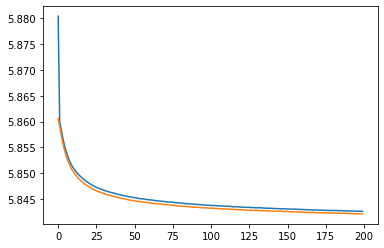

In [25]:
import matplotlib.pyplot as plt
plt.plot([loss / len(dl_train) for loss in losses])
plt.plot([val_loss / len(dl_valid) for val_loss in val_losses])